<a href="https://colab.research.google.com/github/leonmck-dsp-dev/nueraspeech/blob/main/nueraspeech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

In [2]:
# Uncomment the line corresponding to your "runtime type" to run in Google Colab

# CPU:
# !pip install pydub torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# GPU:
# !pip install pydub torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys
from torchaudio import transforms
import matplotlib.pyplot as plt
import IPython.display as ipd
import editdistance
from tqdm import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


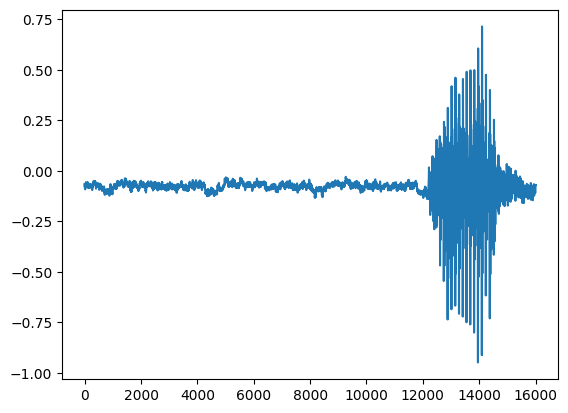

In [5]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

In [6]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

In [7]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

The last file is someone saying “visual”.




In [8]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

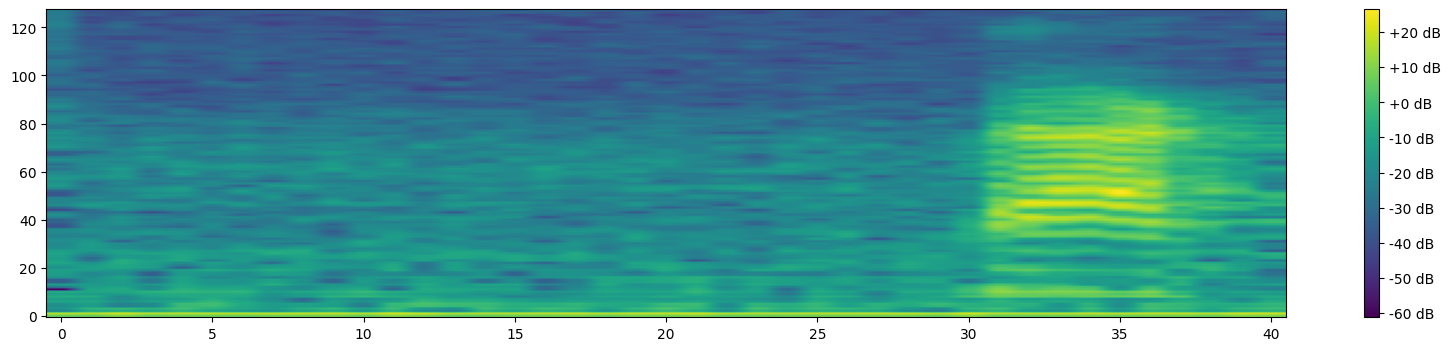

Shape of the Mel spectrogram: torch.Size([1, 128, 41])


In [9]:
new_sample_rate = 8000
import torchaudio
import random
import numpy as np

class SpecAugment:
    def __init__(self, freq_mask_param, time_mask_param, num_time_masks=1, num_freq_masks=1):
        self.freq_mask_param = freq_mask_param
        self.time_mask_param = time_mask_param
        self.num_time_masks = num_time_masks
        self.num_freq_masks = num_freq_masks

    def __call__(self, specs):
        augmented_specs = []
        for spec in specs:
            # Frequency Masking
            for _ in range(self.num_freq_masks):
                num_freqs, num_frames = spec.shape
                f = random.randrange(0, self.freq_mask_param)
                f0 = random.randrange(0, num_freqs - f)
                spec[f0:f0 + f, :] = 0

            # Time Masking
            for _ in range(self.num_time_masks):
                num_freqs, num_frames = spec.shape
                t = random.randrange(0, self.time_mask_param)
                t0 = random.randrange(0, num_frames - t)
                spec[:, t0:t0 + t] = 0

            augmented_specs.append(spec)

        return torch.stack(augmented_specs)


# 1. Resample
resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
resampled_waveform = resampler(waveform)

# 2. Convert to Mel-spectrogram
mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=new_sample_rate, n_mels=128)
mel_spectrogram = mel_transform(resampled_waveform)

# 3. Convert to dB scale
db_transform = torchaudio.transforms.AmplitudeToDB()
db_mel_spectrogram = db_transform(mel_spectrogram)

mel_spectrogram_transform = torch.nn.Sequential(
    torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate),
    torchaudio.transforms.MelSpectrogram(sample_rate=new_sample_rate, n_mels=128),
    torchaudio.transforms.AmplitudeToDB()
)

# Instantiate and apply
spec_augment = SpecAugment(freq_mask_param=30, time_mask_param=30)

# Display
plt.figure(figsize=(20, 4))
plt.imshow(db_mel_spectrogram[0].detach().numpy(), cmap='viridis', origin='lower', aspect='auto')
plt.colorbar(format="%+2.0f dB")
plt.show()

print("Shape of the Mel spectrogram:", mel_spectrogram.shape)
# Listen to the resampled audio
ipd.Audio(resampled_waveform.numpy(), rate=new_sample_rate)


In [10]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))

def index_to_label(tensor):
    # Convert tensor of indices into its string labels
    if tensor.dim() == 0:  # If tensor is a scalar
        return labels[tensor.item()]
    else:  # If tensor is not a scalar
        return [labels[index] for index in tensor.cpu().numpy()]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


In [11]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets
# hyperparameters

cnn = 3
rnn = 5
transformers = 4
head = 4
hidden_dim = 64
dropout = 0.1
dmodel = 128
batch_size = 256
if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [12]:
print(torch.__version__)

2.0.1


# Nueraspeech model architecture
## Acoustic Model (Convolutional Layers)

### Convolutional Neural Networks (CNNs)
A convolutional layer employs a set of learnable filters, which are used to spatially convolve with the input data to produce feature maps. Mathematically, for a 1D input $x$ and a filter $h$, convolution is represented as:

$$
y(t) = (x * h)(t) = \sum_{a=-\infty}^{\infty} x(a)h(t-a)
$$

### Batch Normalization

Batch normalization normalizes the output of a previous activation layer by subtracting the batch mean and dividing by the batch standard deviation.

$$
\hat{x} = \frac{x - \text{E}[x]}{\sqrt{\text{Var}[x]+\epsilon}}
$$

Where:
- $\hat{x}$ is the normalized data.
- $\text{E}[x]$ is the mean of the batch data.
- $\text{Var}[x]$ is the variance of the batch data.
- $\epsilon$ is a small constant to avoid division by zero.

---

## Recurrent Layers (GRU Layers)

### Gated Recurrent Units (GRUs)

GRUs are a type of recurrent neural network (RNN) architecture. The GRU uses gating mechanisms (reset gate and update gate) to control the flow of information.

$$
r_t = \sigma(W_r x_t + U_r h_{t-1} + b_r)
$$
$$
z_t = \sigma(W_z x_t + U_z h_{t-1} + b_z)
$$
$$
\tilde{h}_t = \tanh(W x_t + r_t \odot (U h_{t-1} + b) + b')
$$
$$
h_t = (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t
$$

Where:
- $r_t$ is the reset gate.
- $z_t$ is the update gate.
- $\tilde{h}_t$ is the candidate activation.
- $h_t$ is the output.
- $\sigma$ is the sigmoid function.
- $\odot$ is the element-wise multiplication.

---

## Transformer Attention

### Self Attention

The self-attention mechanism allows the model to weigh the significance of each part in a sequence based on its content. For a query $Q$, key $K$, and value $V$ set, the attention mechanism is defined as:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right) V
$$

Where $d_k$ is the dimension of the keys.

### Multi-head Attention

Instead of using one set of attention weights, multi-head attention uses multiple sets, allowing the model to focus on different parts of the input for different tasks or reasons.

---

## Residual Connections (ResBlocks)

Residual connections (or skip connections) allow for the direct flow of gradients during the backpropagation process. If $x$ is the input and $F(x)$ is the output after some layers, the residual connection is:

$$
\text{output} = x + F(x)
$$

This ensures that even as $F(x)$ learns the residuals (or errors), the original input is preserved.


In [22]:


# Variables you might want to change
experiment_name = "experiment2"
model_name = "nueraspeech"
layers = 'cnn layers:3 rnn layers:5 transformer layers:4 accuracy: 65% loss: 2 avg wer: 0.3 avg cer: 0.2 pre transfer learning'
# Paths
base_path = os.path.join("./results", experiment_name)
plots_path = os.path.join(base_path, "plots")
models_path = os.path.join(base_path, "models")

# Create directories
os.makedirs(plots_path, exist_ok=True)
os.makedirs(models_path, exist_ok=True)

plot_file_path_loss = os.path.join(plots_path, "loss.png")
plot_file_path_accuracy = os.path.join(plots_path, "accourcy.png")
plot_file_path_pred = os.path.join(plots_path, "pred.png")
plot_file_path_errorrate = os.path.join(plots_path, "erro rate.png")
model_file_path = os.path.join(models_path, model_name + ".pth")

plot_file_path_loss, plot_file_path_errorrate, plot_file_path_pred, plot_file_path_accuracy, model_file_path


('./results/experiment2/plots/loss.png',
 './results/experiment2/plots/erro rate.png',
 './results/experiment2/plots/pred.png',
 './results/experiment2/plots/accourcy.png',
 './results/experiment2/models/nueraspeech.pth')

 | experiment  | num cnn | num rnn  | num tranformer | accuarcy |
|----------|----------|----------|----------|----------|
| 1 | 1 | 1 | 2 | 61% |
| 2 | 3| 5 | 4 |  65% |
| 3 | 5| 5 | 8 |    |
| 4 | 5| 7  | 16 |  |


In [14]:
 
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock, self).__init__()

        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn = nn.BatchNorm1d(out_channels)
        self.skip = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn(self.conv(x)))
        out = out + self.skip(x)
        return F.relu(out)
class AcousticModel(nn.Module):
    def __init__(self, n_input, n_channel, num_res_blocks=1):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(2)

        # Allow for multiple residual blocks
        self.resblocks = nn.Sequential(*[ResBlock(n_channel, n_channel) for _ in range(num_res_blocks)])

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.resblocks(x)
        return x

class RecurrentLayers(nn.Module):
    def __init__(self, n_channel, hidden_dim, num_gru_layers=1):
        super().__init__()
        self.gru = nn.GRU(n_channel, hidden_dim, num_layers=num_gru_layers, batch_first=True, bidirectional=True)

    def forward(self, x):
        x, _ = self.gru(x)
        return x
    
class Transformerblock(nn.Module):
    def __init__(self, d_model, heads):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads)  # multi-head attention layer
        self.norm1 = nn.LayerNorm(d_model) # layer normalization
        self.norm2 = nn.LayerNorm(d_model)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.ReLU(),
            nn.Linear(4 * d_model, d_model)
        )   # feed-forward network

    def forward(self, x):
        # For self-attention, query, key, and value are all the same
        attended, _ = self.attention(x, x, x)  
        x = self.norm1(attended + x) # residual connection and layer normalization
        fedforward = self.feed_forward(x) 
        return self.norm2(fedforward + x) # residual connection and layer normalization

class StackedTransformer(nn.Module):
    def __init__(self, d_model, heads, N):
        super(StackedTransformer, self).__init__()
        self.layers = nn.ModuleList([Transformerblock(d_model, heads) for _ in range(N)])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class nueraspeechASR(nn.Module):
    def __init__(self, n_input=1, n_output=35, n_channel=16, hidden_dim=64, dropout_rate=0.4, 
                 num_res_blocks=cnn, num_gru_layers=rnn, d_model=dmodel, heads=head, num_transformer_layers=transformers):
        super().__init__()


        self.acoustic_model = AcousticModel(n_input, n_channel, num_res_blocks=num_res_blocks) 
        self.dim_matching_conv = nn.Conv1d(n_channel, d_model, kernel_size=1)
        self.transformer_to_rnn_fc = nn.Linear(d_model, n_channel)  # n_channel is 16 in this context
        self.recurrent_layers = RecurrentLayers(n_channel, hidden_dim, num_gru_layers=num_gru_layers) 
        self.attention = StackedTransformer(d_model=hidden_dim * 2, heads=heads, N=num_transformer_layers)
        self.output_fc = nn.Linear(hidden_dim*2, n_output)
    
        self.dropout = nn.Dropout(dropout_rate)  
    def forward(self, x):
        x = self.acoustic_model(x)
        x = self.dim_matching_conv(x)
        x = x.permute(0, 2, 1)
        x = self.attention(x)
        x = self.transformer_to_rnn_fc(x)
        x = self.recurrent_layers(x)
        x = self.dropout(x)
        x = x[:, -1, :]
        x = self.output_fc(x) 
        return F.log_softmax(x, dim=1)


# Testing the model
n_input = 128
n_output = 35

model = nueraspeechASR(n_input=n_input, n_output=n_output)
print(model)

# Print number of parameters
print(f'The model has {sum(p.numel() for p in model.parameters()):,} trainable parameters')

# Test
x = torch.randn(1, 128, 8000)
OUT = model(x)
print(OUT.shape)


nueraspeechASR(
  (acoustic_model): AcousticModel(
    (conv1): Conv1d(128, 16, kernel_size=(5,), stride=(2,))
    (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (resblocks): Sequential(
      (0): ResBlock(
        (conv): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (skip): Sequential()
      )
      (1): ResBlock(
        (conv): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (skip): Sequential()
      )
      (2): ResBlock(
        (conv): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [15]:
# @title Default title tex

n_epoch = 10
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=0.0001)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

pbar = tqdm(total=len(train_loader.dataset), desc="Training Progress")

experiment_name = "experiment2"
model_name = models_path+"/nueraspeech.pth"

Training Progress:   0%|          | 0/84843 [00:00<?, ?it/s]

In [16]:

loss_over_epochs = []
def train(model, epoch, log_interval):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.squeeze(1)  # This will remove the single channel dimension, turning [batch_size, 1, 128, 41] into [batch_size, 128, 41]

        # Preprocess the data with Mel-spectrogram transform
        data = mel_spectrogram_transform(data)

        # Apply SpecAugment (only during training)
        data = spec_augment(data)
        data = data.to(device)


        target = target.to(device)

        output = model(data)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        loss_over_epochs.append(loss.item())


In [17]:
def wer(s1, s2):

    b = set(s1 + s2)
    word2char = dict(zip(b, range(len(b))))

    w1 = [chr(word2char[w]) for w in s1]
    w2 = [chr(word2char[w]) for w in s2]

    return editdistance.eval(" ".join(w1), " ".join(w2)) / len(s2)
def cer(s1, s2): 
    s1 = " ".join(s1)
    s2 = " ".join(s2)

    return editdistance.eval(s1, s2) / len(s2)


def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)
wer_over_epochs = []
cer_over_epochs = []
correct_predictions_over_epochs = []

def test(model, epoch):
    model.eval()
    correct = 0
    total_wer, total_cer, total_samples = 0, 0, 0

    for data, target in test_loader:
        # Apply Mel-spectrogram transform
        data = mel_spectrogram_transform(data)

        # Remove channel dimension after applying mel transform
        data = data.squeeze(1)  # This will convert [batch_size, 1, 128, 41] into [batch_size, 128, 41]

        data = data.to(device)
        target = target.to(device)

        output = model(data)
        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # Compute WER and CER
        pred_str = index_to_label(pred)  # Convert the prediction indices to string
        target_str = index_to_label(target)  # Convert target indices to string

        total_wer += wer(pred_str, target_str)
        total_cer += cer(pred_str, target_str)
        total_samples += 1

        # update progress bar
        pbar.update(pbar_update)

    avg_wer = total_wer / total_samples
    avg_cer = total_cer / total_samples


    accuracy = correct / len(test_loader.dataset)
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)")
    print(f"Average WER: {avg_wer:.4f}\nAverage CER: {avg_cer:.4f}\n")

    return avg_wer, avg_cer, correct, accuracy

In [18]:
log_interval = 20
pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []
model = model.to(device)


accuracy_over_epochs = []
for epoch in range(1, n_epoch + 1):
    train(model, epoch, log_interval)
    # Evaluate the model
    avg_wer, avg_cer, correct, accuracy = test(model, epoch)

    # Store the metrics for plotting or further analysis
    wer_over_epochs.append(avg_wer)
    cer_over_epochs.append(avg_cer)
    correct_predictions_over_epochs.append(correct) 
    scheduler.step()
   # Save
    torch.save(model.state_dict(), model_name)
    print("saved")
# Let's plot the training loss versus the number of iteration.
# plt.plot(losses);
# plt.title("training loss");

Training Progress:   0%|          | 0.0026666666666666666/84843 [00:00<4627:00:41, 196.33s/it]

Train Epoch: 1 [0/84843 (0%)]	Loss: 3.543635


Training Progress:   0%|          | 0.05599999999999999/84843 [00:08<3757:04:47, 159.42s/it]  

Train Epoch: 1 [5120/84843 (6%)]	Loss: 3.501551


Training Progress:   0%|          | 0.10933333333333328/84843 [00:15<3196:57:32, 135.65s/it] 

Train Epoch: 1 [10240/84843 (12%)]	Loss: 3.512843


Training Progress:   0%|          | 0.16266666666666676/84843 [00:23<3162:57:18, 134.21s/it]

Train Epoch: 1 [15360/84843 (18%)]	Loss: 3.484113


Training Progress:   0%|          | 0.21600000000000033/84843 [00:30<3219:09:46, 136.59s/it]

Train Epoch: 1 [20480/84843 (24%)]	Loss: 3.527506


Training Progress:   0%|          | 0.2693333333333337/84843 [00:37<3258:03:24, 138.24s/it] 

Train Epoch: 1 [25600/84843 (30%)]	Loss: 3.442131


Training Progress:   0%|          | 0.3226666666666667/84843 [00:44<3182:52:03, 135.05s/it] 

Train Epoch: 1 [30720/84843 (36%)]	Loss: 3.383683


Training Progress:   0%|          | 0.3759999999999997/84843 [00:52<3208:10:41, 136.13s/it] 

Train Epoch: 1 [35840/84843 (42%)]	Loss: 3.397599


Training Progress:   0%|          | 0.42933333333333273/84843 [00:59<3161:59:34, 134.17s/it]

Train Epoch: 1 [40960/84843 (48%)]	Loss: 3.388515


Training Progress:   0%|          | 0.48266666666666574/84843 [01:07<3790:42:03, 160.85s/it]

Train Epoch: 1 [46080/84843 (54%)]	Loss: 3.321408


Training Progress:   0%|          | 0.5359999999999995/84843 [01:15<3567:32:50, 151.38s/it] 

Train Epoch: 1 [51200/84843 (60%)]	Loss: 3.276278


Training Progress:   0%|          | 0.5893333333333336/84843 [01:23<3368:21:25, 142.92s/it]

Train Epoch: 1 [56320/84843 (66%)]	Loss: 3.290997


Training Progress:   0%|          | 0.6426666666666677/84843 [01:30<3360:42:53, 142.60s/it]

Train Epoch: 1 [61440/84843 (72%)]	Loss: 3.297837


Training Progress:   0%|          | 0.6960000000000018/84843 [01:38<3516:18:50, 149.20s/it]

Train Epoch: 1 [66560/84843 (78%)]	Loss: 3.316542


Training Progress:   0%|          | 0.749333333333336/84843 [01:46<3384:41:37, 143.62s/it] 

Train Epoch: 1 [71680/84843 (84%)]	Loss: 3.302928


Training Progress:   0%|          | 0.8026666666666701/84843 [01:54<3417:09:51, 145.00s/it]

Train Epoch: 1 [76800/84843 (90%)]	Loss: 3.228256


Training Progress:   0%|          | 0.8560000000000042/84843 [02:02<3854:20:58, 163.55s/it]

Train Epoch: 1 [81920/84843 (96%)]	Loss: 3.293770


Training Progress:   0%|          | 1.0000000000000062/84843 [02:17<2092:35:59, 88.79s/it] 


Test Epoch: 1	Accuracy: 1088/11005 (10%)
Average WER: 0.9011
Average CER: 0.7118

saved


Training Progress:   0%|          | 1.0026666666666728/84843 [02:18<2665:49:56, 113.12s/it]

Train Epoch: 2 [0/84843 (0%)]	Loss: 3.251596


Training Progress:   0%|          | 1.0560000000000047/84843 [02:26<3542:20:17, 150.31s/it]

Train Epoch: 2 [5120/84843 (6%)]	Loss: 3.136291


Training Progress:   0%|          | 1.1093333333333366/84843 [02:34<3531:30:46, 149.85s/it]

Train Epoch: 2 [10240/84843 (12%)]	Loss: 3.136704


Training Progress:   0%|          | 1.1626666666666685/84843 [02:43<3524:55:08, 149.57s/it]

Train Epoch: 2 [15360/84843 (18%)]	Loss: 3.084925


Training Progress:   0%|          | 1.2160000000000004/84843 [02:51<3634:11:42, 154.21s/it]

Train Epoch: 2 [20480/84843 (24%)]	Loss: 2.989539


Training Progress:   0%|          | 1.2693333333333323/84843 [02:58<3521:04:48, 149.41s/it]

Train Epoch: 2 [25600/84843 (30%)]	Loss: 3.124920


Training Progress:   0%|          | 1.3226666666666642/84843 [03:08<4095:36:00, 173.78s/it]

Train Epoch: 2 [30720/84843 (36%)]	Loss: 3.114236


Training Progress:   0%|          | 1.3759999999999961/84843 [03:16<3584:57:17, 152.12s/it]

Train Epoch: 2 [35840/84843 (42%)]	Loss: 3.058573


Training Progress:   0%|          | 1.429333333333328/84843 [03:24<3766:34:50, 159.82s/it] 

Train Epoch: 2 [40960/84843 (48%)]	Loss: 3.063954


Training Progress:   0%|          | 1.48266666666666/84843 [03:32<3574:53:33, 151.69s/it]  

Train Epoch: 2 [46080/84843 (54%)]	Loss: 3.101154


Training Progress:   0%|          | 1.5359999999999918/84843 [03:41<3705:00:33, 157.21s/it]

Train Epoch: 2 [51200/84843 (60%)]	Loss: 2.975021


Training Progress:   0%|          | 1.5893333333333237/84843 [03:49<3546:35:22, 150.49s/it]

Train Epoch: 2 [56320/84843 (66%)]	Loss: 3.004072


Training Progress:   0%|          | 1.6426666666666556/84843 [03:57<3587:25:49, 152.22s/it]

Train Epoch: 2 [61440/84843 (72%)]	Loss: 3.006950


Training Progress:   0%|          | 1.6959999999999875/84843 [04:06<4431:29:05, 188.04s/it]

Train Epoch: 2 [66560/84843 (78%)]	Loss: 2.984729


Training Progress:   0%|          | 1.7493333333333194/84843 [04:14<3549:50:14, 150.63s/it]

Train Epoch: 2 [71680/84843 (84%)]	Loss: 2.797181


Training Progress:   0%|          | 1.8026666666666513/84843 [04:22<3513:55:13, 149.10s/it]

Train Epoch: 2 [76800/84843 (90%)]	Loss: 2.936348


Training Progress:   0%|          | 1.8559999999999832/84843 [04:31<3644:34:02, 154.65s/it]

Train Epoch: 2 [81920/84843 (96%)]	Loss: 3.010994


Training Progress:   0%|          | 1.9999999999999793/84843 [04:46<2000:10:38, 84.87s/it] 


Test Epoch: 2	Accuracy: 1833/11005 (17%)
Average WER: 0.8335
Average CER: 0.6525

saved


Training Progress:   0%|          | 2.002666666666646/84843 [04:46<2575:19:44, 109.28s/it]

Train Epoch: 3 [0/84843 (0%)]	Loss: 2.811954


Training Progress:   0%|          | 2.0559999999999823/84843 [04:55<3687:35:59, 156.47s/it]

Train Epoch: 3 [5120/84843 (6%)]	Loss: 2.837807


Training Progress:   0%|          | 2.1093333333333186/84843 [05:03<3752:00:58, 159.21s/it]

Train Epoch: 3 [10240/84843 (12%)]	Loss: 2.937127


Training Progress:   0%|          | 2.162666666666655/84843 [05:12<3710:35:48, 157.45s/it] 

Train Epoch: 3 [15360/84843 (18%)]	Loss: 2.937481


Training Progress:   0%|          | 2.2159999999999913/84843 [05:21<3601:48:54, 152.83s/it]

Train Epoch: 3 [20480/84843 (24%)]	Loss: 2.906179


Training Progress:   0%|          | 2.2693333333333277/84843 [05:29<3676:19:29, 156.00s/it]

Train Epoch: 3 [25600/84843 (30%)]	Loss: 2.782779


Training Progress:   0%|          | 2.322666666666664/84843 [05:37<3620:54:27, 153.64s/it] 

Train Epoch: 3 [30720/84843 (36%)]	Loss: 2.811005


Training Progress:   0%|          | 2.3760000000000003/84843 [05:46<3664:26:30, 155.49s/it]

Train Epoch: 3 [35840/84843 (42%)]	Loss: 2.913814


Training Progress:   0%|          | 2.4293333333333367/84843 [05:54<3559:50:53, 151.05s/it]

Train Epoch: 3 [40960/84843 (48%)]	Loss: 2.907824


Training Progress:   0%|          | 2.482666666666673/84843 [06:02<3797:10:07, 161.12s/it] 

Train Epoch: 3 [46080/84843 (54%)]	Loss: 2.908780


Training Progress:   0%|          | 2.5360000000000094/84843 [06:11<3670:52:38, 155.76s/it]

Train Epoch: 3 [51200/84843 (60%)]	Loss: 2.868171


Training Progress:   0%|          | 2.5893333333333457/84843 [06:20<3618:05:01, 153.52s/it]

Train Epoch: 3 [56320/84843 (66%)]	Loss: 2.741232


Training Progress:   0%|          | 2.642666666666682/84843 [06:28<3709:42:57, 157.41s/it] 

Train Epoch: 3 [61440/84843 (72%)]	Loss: 2.715899


Training Progress:   0%|          | 2.6960000000000184/84843 [06:36<3723:58:18, 158.02s/it]

Train Epoch: 3 [66560/84843 (78%)]	Loss: 2.778801


Training Progress:   0%|          | 2.7493333333333547/84843 [06:45<3532:50:20, 149.91s/it]

Train Epoch: 3 [71680/84843 (84%)]	Loss: 2.714559


Training Progress:   0%|          | 2.802666666666691/84843 [06:53<3586:29:38, 152.18s/it] 

Train Epoch: 3 [76800/84843 (90%)]	Loss: 2.777762


Training Progress:   0%|          | 2.8560000000000274/84843 [07:01<3656:12:37, 155.14s/it]

Train Epoch: 3 [81920/84843 (96%)]	Loss: 2.803147


Training Progress:   0%|          | 3.0000000000000355/84843 [07:16<1990:38:34, 84.47s/it] 


Test Epoch: 3	Accuracy: 3550/11005 (32%)
Average WER: 0.6775
Average CER: 0.5091

saved


Training Progress:   0%|          | 3.0026666666667023/84843 [07:16<2649:19:32, 112.42s/it]

Train Epoch: 4 [0/84843 (0%)]	Loss: 2.704715


Training Progress:   0%|          | 3.0560000000000387/84843 [07:25<3717:05:40, 157.73s/it]

Train Epoch: 4 [5120/84843 (6%)]	Loss: 2.654374


Training Progress:   0%|          | 3.109333333333375/84843 [07:33<3713:02:35, 157.56s/it] 

Train Epoch: 4 [10240/84843 (12%)]	Loss: 2.678813


Training Progress:   0%|          | 3.1626666666667114/84843 [07:41<3564:50:46, 151.27s/it]

Train Epoch: 4 [15360/84843 (18%)]	Loss: 2.743511


Training Progress:   0%|          | 3.2160000000000477/84843 [07:50<3594:55:49, 152.54s/it]

Train Epoch: 4 [20480/84843 (24%)]	Loss: 2.587386


Training Progress:   0%|          | 3.269333333333384/84843 [07:58<3551:10:26, 150.69s/it] 

Train Epoch: 4 [25600/84843 (30%)]	Loss: 2.666955


Training Progress:   0%|          | 3.3226666666667204/84843 [08:07<4292:28:25, 182.14s/it]

Train Epoch: 4 [30720/84843 (36%)]	Loss: 2.588788


Training Progress:   0%|          | 3.3760000000000567/84843 [08:15<3720:10:56, 157.86s/it]

Train Epoch: 4 [35840/84843 (42%)]	Loss: 2.594594


Training Progress:   0%|          | 3.429333333333393/84843 [08:23<3524:18:33, 149.55s/it] 

Train Epoch: 4 [40960/84843 (48%)]	Loss: 2.683600


Training Progress:   0%|          | 3.4826666666667294/84843 [08:32<3649:03:13, 154.84s/it]

Train Epoch: 4 [46080/84843 (54%)]	Loss: 2.722893


Training Progress:   0%|          | 3.5360000000000658/84843 [08:40<3687:32:55, 156.47s/it]

Train Epoch: 4 [51200/84843 (60%)]	Loss: 2.634044


Training Progress:   0%|          | 3.589333333333402/84843 [08:48<3641:11:26, 154.51s/it] 

Train Epoch: 4 [56320/84843 (66%)]	Loss: 2.681713


Training Progress:   0%|          | 3.6426666666667384/84843 [08:57<3560:55:09, 151.10s/it]

Train Epoch: 4 [61440/84843 (72%)]	Loss: 2.593079


Training Progress:   0%|          | 3.696000000000075/84843 [09:05<3523:23:28, 149.51s/it] 

Train Epoch: 4 [66560/84843 (78%)]	Loss: 2.828197


Training Progress:   0%|          | 3.749333333333411/84843 [09:14<3626:16:08, 153.87s/it] 

Train Epoch: 4 [71680/84843 (84%)]	Loss: 2.509114


Training Progress:   0%|          | 3.8026666666667475/84843 [09:22<3855:49:40, 163.62s/it]

Train Epoch: 4 [76800/84843 (90%)]	Loss: 2.496100


Training Progress:   0%|          | 3.856000000000084/84843 [09:30<3808:12:20, 161.59s/it] 

Train Epoch: 4 [81920/84843 (96%)]	Loss: 2.572441


Training Progress:   0%|          | 4.0000000000000915/84843 [09:45<2308:26:19, 97.95s/it] 


Test Epoch: 4	Accuracy: 4858/11005 (44%)
Average WER: 0.5586
Average CER: 0.4287

saved


Training Progress:   0%|          | 4.002666666666758/84843 [09:45<2744:00:01, 116.44s/it]

Train Epoch: 5 [0/84843 (0%)]	Loss: 2.735575


Training Progress:   0%|          | 4.056000000000085/84843 [09:53<3628:57:39, 153.99s/it] 

Train Epoch: 5 [5120/84843 (6%)]	Loss: 2.612341


Training Progress:   0%|          | 4.109333333333413/84843 [10:02<3585:57:42, 152.16s/it] 

Train Epoch: 5 [10240/84843 (12%)]	Loss: 2.365720


Training Progress:   0%|          | 4.16266666666674/84843 [10:11<3685:19:50, 156.38s/it]  

Train Epoch: 5 [15360/84843 (18%)]	Loss: 2.550685


Training Progress:   0%|          | 4.216000000000068/84843 [10:19<3878:19:12, 164.57s/it] 

Train Epoch: 5 [20480/84843 (24%)]	Loss: 2.487290


Training Progress:   0%|          | 4.269333333333395/84843 [10:28<3651:52:55, 154.96s/it] 

Train Epoch: 5 [25600/84843 (30%)]	Loss: 2.517295


Training Progress:   0%|          | 4.322666666666723/84843 [10:36<3481:29:07, 147.73s/it] 

Train Epoch: 5 [30720/84843 (36%)]	Loss: 2.512148


Training Progress:   0%|          | 4.37600000000005/84843 [10:44<3459:39:05, 146.81s/it]  

Train Epoch: 5 [35840/84843 (42%)]	Loss: 2.502271


Training Progress:   0%|          | 4.4293333333333775/84843 [10:52<3523:20:31, 149.51s/it]

Train Epoch: 5 [40960/84843 (48%)]	Loss: 2.551629


Training Progress:   0%|          | 4.482666666666705/84843 [11:00<3787:57:51, 160.74s/it] 

Train Epoch: 5 [46080/84843 (54%)]	Loss: 2.651208


Training Progress:   0%|          | 4.5360000000000325/84843 [11:09<3979:15:07, 168.85s/it]

Train Epoch: 5 [51200/84843 (60%)]	Loss: 2.479329


Training Progress:   0%|          | 4.58933333333336/84843 [11:17<3628:06:11, 153.95s/it]  

Train Epoch: 5 [56320/84843 (66%)]	Loss: 2.424345


Training Progress:   0%|          | 4.642666666666687/84843 [11:26<3602:45:25, 152.88s/it] 

Train Epoch: 5 [61440/84843 (72%)]	Loss: 2.276109


Training Progress:   0%|          | 4.696000000000015/84843 [11:34<3509:59:14, 148.94s/it] 

Train Epoch: 5 [66560/84843 (78%)]	Loss: 2.470612


Training Progress:   0%|          | 4.749333333333342/84843 [11:42<3604:38:57, 152.96s/it] 

Train Epoch: 5 [71680/84843 (84%)]	Loss: 2.431640


Training Progress:   0%|          | 4.80266666666667/84843 [11:50<3508:35:21, 148.88s/it]  

Train Epoch: 5 [76800/84843 (90%)]	Loss: 2.448960


Training Progress:   0%|          | 4.855999999999997/84843 [11:58<3591:26:34, 152.40s/it] 

Train Epoch: 5 [81920/84843 (96%)]	Loss: 2.188754


Training Progress:   0%|          | 4.999999999999981/84843 [12:13<1947:55:40, 82.66s/it]  


Test Epoch: 5	Accuracy: 5430/11005 (49%)
Average WER: 0.5066
Average CER: 0.3864

saved


Training Progress:   0%|          | 5.002666666666648/84843 [12:14<2441:05:35, 103.58s/it]

Train Epoch: 6 [0/84843 (0%)]	Loss: 2.324651


Training Progress:   0%|          | 5.055999999999975/84843 [12:22<3575:26:02, 151.72s/it] 

Train Epoch: 6 [5120/84843 (6%)]	Loss: 2.501880


Training Progress:   0%|          | 5.109333333333303/84843 [12:30<3539:26:28, 150.19s/it] 

Train Epoch: 6 [10240/84843 (12%)]	Loss: 2.323234


Training Progress:   0%|          | 5.16266666666663/84843 [12:39<3734:05:14, 158.45s/it]  

Train Epoch: 6 [15360/84843 (18%)]	Loss: 2.394707


Training Progress:   0%|          | 5.215999999999958/84843 [12:47<3693:18:11, 156.72s/it] 

Train Epoch: 6 [20480/84843 (24%)]	Loss: 2.311269


Training Progress:   0%|          | 5.269333333333285/84843 [12:56<3582:56:35, 152.04s/it] 

Train Epoch: 6 [25600/84843 (30%)]	Loss: 2.305918


Training Progress:   0%|          | 5.3226666666666125/84843 [13:04<3623:28:35, 153.76s/it]

Train Epoch: 6 [30720/84843 (36%)]	Loss: 2.227864


Training Progress:   0%|          | 5.37599999999994/84843 [13:13<3650:52:38, 154.92s/it]  

Train Epoch: 6 [35840/84843 (42%)]	Loss: 2.244259


Training Progress:   0%|          | 5.429333333333267/84843 [13:21<3625:07:32, 153.83s/it] 

Train Epoch: 6 [40960/84843 (48%)]	Loss: 2.401850


Training Progress:   0%|          | 5.482666666666595/84843 [13:29<3780:01:50, 160.40s/it] 

Train Epoch: 6 [46080/84843 (54%)]	Loss: 2.433933


Training Progress:   0%|          | 5.535999999999922/84843 [13:38<3599:01:03, 152.72s/it] 

Train Epoch: 6 [51200/84843 (60%)]	Loss: 2.377867


Training Progress:   0%|          | 5.58933333333325/84843 [13:46<3619:40:21, 153.60s/it]  

Train Epoch: 6 [56320/84843 (66%)]	Loss: 2.258319


Training Progress:   0%|          | 5.642666666666577/84843 [13:55<3608:03:41, 153.10s/it] 

Train Epoch: 6 [61440/84843 (72%)]	Loss: 2.401544


Training Progress:   0%|          | 5.695999999999905/84843 [14:03<4008:13:38, 170.09s/it] 

Train Epoch: 6 [66560/84843 (78%)]	Loss: 2.325001


Training Progress:   0%|          | 5.749333333333232/84843 [14:13<3634:47:21, 154.24s/it] 

Train Epoch: 6 [71680/84843 (84%)]	Loss: 2.244431


Training Progress:   0%|          | 5.80266666666656/84843 [14:21<3578:44:50, 151.86s/it]  

Train Epoch: 6 [76800/84843 (90%)]	Loss: 2.326850


Training Progress:   0%|          | 5.855999999999887/84843 [14:29<3597:24:44, 152.65s/it] 

Train Epoch: 6 [81920/84843 (96%)]	Loss: 2.317214


Training Progress:   0%|          | 5.999999999999871/84843 [14:44<2010:34:33, 85.32s/it]  


Test Epoch: 6	Accuracy: 6127/11005 (56%)
Average WER: 0.4433
Average CER: 0.3463

saved


Training Progress:   0%|          | 6.002666666666538/84843 [14:45<2517:14:37, 106.82s/it]

Train Epoch: 7 [0/84843 (0%)]	Loss: 2.200323


Training Progress:   0%|          | 6.055999999999865/84843 [14:53<3622:33:01, 153.72s/it] 

Train Epoch: 7 [5120/84843 (6%)]	Loss: 2.365729


Training Progress:   0%|          | 6.1093333333331925/84843 [15:01<3594:05:50, 152.51s/it]

Train Epoch: 7 [10240/84843 (12%)]	Loss: 2.289946


Training Progress:   0%|          | 6.16266666666652/84843 [15:10<3742:21:10, 158.80s/it]  

Train Epoch: 7 [15360/84843 (18%)]	Loss: 2.208690


Training Progress:   0%|          | 6.215999999999847/84843 [15:18<3692:07:03, 156.67s/it] 

Train Epoch: 7 [20480/84843 (24%)]	Loss: 2.332270


Training Progress:   0%|          | 6.269333333333175/84843 [15:27<3459:12:41, 146.79s/it] 

Train Epoch: 7 [25600/84843 (30%)]	Loss: 2.273206


Training Progress:   0%|          | 6.322666666666502/84843 [15:35<3579:38:50, 151.90s/it] 

Train Epoch: 7 [30720/84843 (36%)]	Loss: 2.185173


Training Progress:   0%|          | 6.37599999999983/84843 [15:43<3540:25:06, 150.24s/it]  

Train Epoch: 7 [35840/84843 (42%)]	Loss: 2.193943


Training Progress:   0%|          | 6.429333333333157/84843 [15:51<3675:19:16, 155.96s/it] 

Train Epoch: 7 [40960/84843 (48%)]	Loss: 2.036812


Training Progress:   0%|          | 6.482666666666485/84843 [15:59<3500:28:52, 148.54s/it] 

Train Epoch: 7 [46080/84843 (54%)]	Loss: 2.127378


Training Progress:   0%|          | 6.535999999999812/84843 [16:08<4042:07:17, 171.53s/it] 

Train Epoch: 7 [51200/84843 (60%)]	Loss: 2.173448


Training Progress:   0%|          | 6.58933333333314/84843 [16:16<3575:14:27, 151.71s/it]  

Train Epoch: 7 [56320/84843 (66%)]	Loss: 2.312057


Training Progress:   0%|          | 6.642666666666467/84843 [16:25<4199:46:31, 178.22s/it] 

Train Epoch: 7 [61440/84843 (72%)]	Loss: 1.943138


Training Progress:   0%|          | 6.695999999999795/84843 [16:33<3562:48:35, 151.19s/it] 

Train Epoch: 7 [66560/84843 (78%)]	Loss: 2.031978


Training Progress:   0%|          | 6.749333333333122/84843 [16:41<3558:32:26, 151.01s/it] 

Train Epoch: 7 [71680/84843 (84%)]	Loss: 2.292392


Training Progress:   0%|          | 6.8026666666664495/84843 [16:50<3649:21:59, 154.86s/it]

Train Epoch: 7 [76800/84843 (90%)]	Loss: 2.241796


Training Progress:   0%|          | 6.855999999999777/84843 [16:58<3591:08:00, 152.39s/it] 

Train Epoch: 7 [81920/84843 (96%)]	Loss: 2.278563


Training Progress:   0%|          | 6.999999999999761/84843 [17:14<2256:06:17, 95.74s/it]  


Test Epoch: 7	Accuracy: 6334/11005 (58%)
Average WER: 0.4244
Average CER: 0.3217

saved


Training Progress:   0%|          | 7.0026666666664275/84843 [17:14<2910:18:18, 123.50s/it]

Train Epoch: 8 [0/84843 (0%)]	Loss: 2.259611


Training Progress:   0%|          | 7.055999999999755/84843 [17:24<3724:45:05, 158.06s/it] 

Train Epoch: 8 [5120/84843 (6%)]	Loss: 2.252813


Training Progress:   0%|          | 7.109333333333082/84843 [17:32<3727:57:19, 158.20s/it] 

Train Epoch: 8 [10240/84843 (12%)]	Loss: 2.165676


Training Progress:   0%|          | 7.16266666666641/84843 [17:40<3640:15:14, 154.47s/it]  

Train Epoch: 8 [15360/84843 (18%)]	Loss: 2.067858


Training Progress:   0%|          | 7.215999999999737/84843 [17:49<3578:00:49, 151.83s/it] 

Train Epoch: 8 [20480/84843 (24%)]	Loss: 2.212804


Training Progress:   0%|          | 7.269333333333065/84843 [17:57<3590:02:06, 152.34s/it] 

Train Epoch: 8 [25600/84843 (30%)]	Loss: 2.258106


Training Progress:   0%|          | 7.322666666666392/84843 [18:05<3573:42:29, 151.65s/it] 

Train Epoch: 8 [30720/84843 (36%)]	Loss: 2.297884


Training Progress:   0%|          | 7.37599999999972/84843 [18:14<3514:44:00, 149.15s/it]  

Train Epoch: 8 [35840/84843 (42%)]	Loss: 2.243516


Training Progress:   0%|          | 7.429333333333047/84843 [18:22<3530:42:12, 149.83s/it] 

Train Epoch: 8 [40960/84843 (48%)]	Loss: 2.178117


Training Progress:   0%|          | 7.482666666666375/84843 [18:30<3491:01:00, 148.14s/it] 

Train Epoch: 8 [46080/84843 (54%)]	Loss: 2.277621


Training Progress:   0%|          | 7.535999999999702/84843 [18:38<3601:15:53, 152.82s/it] 

Train Epoch: 8 [51200/84843 (60%)]	Loss: 2.247314


Training Progress:   0%|          | 7.5893333333330295/84843 [18:46<3583:46:14, 152.08s/it]

Train Epoch: 8 [56320/84843 (66%)]	Loss: 2.136989


Training Progress:   0%|          | 7.642666666666357/84843 [18:54<3552:43:29, 150.76s/it] 

Train Epoch: 8 [61440/84843 (72%)]	Loss: 2.276058


Training Progress:   0%|          | 7.695999999999684/84843 [19:03<3863:37:03, 163.95s/it] 

Train Epoch: 8 [66560/84843 (78%)]	Loss: 2.058443


Training Progress:   0%|          | 7.749333333333012/84843 [19:12<3744:38:36, 158.90s/it] 

Train Epoch: 8 [71680/84843 (84%)]	Loss: 2.243942


Training Progress:   0%|          | 7.802666666666339/84843 [19:20<3616:49:54, 153.48s/it] 

Train Epoch: 8 [76800/84843 (90%)]	Loss: 2.114833


Training Progress:   0%|          | 7.855999999999667/84843 [19:28<3568:42:52, 151.44s/it] 

Train Epoch: 8 [81920/84843 (96%)]	Loss: 2.273224


Training Progress:   0%|          | 7.999999999999651/84843 [19:43<1945:29:50, 82.56s/it]  


Test Epoch: 8	Accuracy: 6692/11005 (61%)
Average WER: 0.3919
Average CER: 0.2906

saved


Training Progress:   0%|          | 8.002666666666318/84843 [19:43<2418:17:46, 102.62s/it]

Train Epoch: 9 [0/84843 (0%)]	Loss: 2.063172


Training Progress:   0%|          | 8.055999999999646/84843 [19:51<3554:16:32, 150.83s/it]

Train Epoch: 9 [5120/84843 (6%)]	Loss: 2.311364


Training Progress:   0%|          | 8.109333333332973/84843 [20:00<3653:18:07, 155.03s/it]

Train Epoch: 9 [10240/84843 (12%)]	Loss: 2.049409


Training Progress:   0%|          | 8.1626666666663/84843 [20:08<3895:53:32, 165.32s/it]  

Train Epoch: 9 [15360/84843 (18%)]	Loss: 2.113014


Training Progress:   0%|          | 8.215999999999628/84843 [20:16<3657:41:10, 155.22s/it]

Train Epoch: 9 [20480/84843 (24%)]	Loss: 2.222852


Training Progress:   0%|          | 8.269333333332956/84843 [20:24<3523:59:01, 149.54s/it]

Train Epoch: 9 [25600/84843 (30%)]	Loss: 2.205163


Training Progress:   0%|          | 8.322666666666283/84843 [20:33<3539:37:04, 150.21s/it]

Train Epoch: 9 [30720/84843 (36%)]	Loss: 2.199944


Training Progress:   0%|          | 8.37599999999961/84843 [20:41<3590:56:48, 152.38s/it] 

Train Epoch: 9 [35840/84843 (42%)]	Loss: 2.181003


Training Progress:   0%|          | 8.429333333332938/84843 [20:49<3632:30:44, 154.15s/it]

Train Epoch: 9 [40960/84843 (48%)]	Loss: 2.080194


Training Progress:   0%|          | 8.482666666666265/84843 [20:57<3507:52:17, 148.86s/it]

Train Epoch: 9 [46080/84843 (54%)]	Loss: 2.316414


Training Progress:   0%|          | 8.535999999999593/84843 [21:05<3590:00:00, 152.34s/it]

Train Epoch: 9 [51200/84843 (60%)]	Loss: 2.145701


Training Progress:   0%|          | 8.58933333333292/84843 [21:14<3701:33:59, 157.08s/it] 

Train Epoch: 9 [56320/84843 (66%)]	Loss: 2.128535


Training Progress:   0%|          | 8.642666666666248/84843 [21:22<3596:58:30, 152.64s/it]

Train Epoch: 9 [61440/84843 (72%)]	Loss: 2.049186


Training Progress:   0%|          | 8.695999999999575/84843 [21:30<3548:52:24, 150.60s/it]

Train Epoch: 9 [66560/84843 (78%)]	Loss: 2.046804


Training Progress:   0%|          | 8.749333333332903/84843 [21:38<3621:57:59, 153.70s/it]

Train Epoch: 9 [71680/84843 (84%)]	Loss: 2.071468


Training Progress:   0%|          | 8.80266666666623/84843 [21:47<3729:40:33, 158.27s/it] 

Train Epoch: 9 [76800/84843 (90%)]	Loss: 2.044106


Training Progress:   0%|          | 8.855999999999558/84843 [21:55<3599:17:39, 152.74s/it]

Train Epoch: 9 [81920/84843 (96%)]	Loss: 2.070957


Training Progress:   0%|          | 8.999999999999542/84843 [22:10<2126:55:37, 90.26s/it] 


Test Epoch: 9	Accuracy: 6889/11005 (63%)
Average WER: 0.3740
Average CER: 0.2802

saved


Training Progress:   0%|          | 9.002666666666208/84843 [22:10<2811:58:32, 119.33s/it]

Train Epoch: 10 [0/84843 (0%)]	Loss: 1.994486


Training Progress:   0%|          | 9.055999999999536/84843 [22:18<3638:08:45, 154.39s/it]

Train Epoch: 10 [5120/84843 (6%)]	Loss: 2.245937


Training Progress:   0%|          | 9.109333333332863/84843 [22:27<3536:43:27, 150.08s/it]

Train Epoch: 10 [10240/84843 (12%)]	Loss: 2.082857


Training Progress:   0%|          | 9.16266666666619/84843 [22:35<3549:45:18, 150.64s/it] 

Train Epoch: 10 [15360/84843 (18%)]	Loss: 2.003979


Training Progress:   0%|          | 9.215999999999518/84843 [22:43<3802:41:34, 161.37s/it]

Train Epoch: 10 [20480/84843 (24%)]	Loss: 2.047958


Training Progress:   0%|          | 9.269333333332845/84843 [22:51<3758:15:40, 159.49s/it]

Train Epoch: 10 [25600/84843 (30%)]	Loss: 2.117949


Training Progress:   0%|          | 9.322666666666173/84843 [23:00<3594:13:28, 152.52s/it]

Train Epoch: 10 [30720/84843 (36%)]	Loss: 2.084606


Training Progress:   0%|          | 9.3759999999995/84843 [23:09<3653:40:27, 155.05s/it]  

Train Epoch: 10 [35840/84843 (42%)]	Loss: 2.111909


Training Progress:   0%|          | 9.429333333332828/84843 [23:17<3611:42:27, 153.27s/it]

Train Epoch: 10 [40960/84843 (48%)]	Loss: 1.993775


Training Progress:   0%|          | 9.482666666666155/84843 [23:25<3515:09:52, 149.17s/it]

Train Epoch: 10 [46080/84843 (54%)]	Loss: 2.177647


Training Progress:   0%|          | 9.535999999999483/84843 [23:33<3555:59:07, 150.90s/it]

Train Epoch: 10 [51200/84843 (60%)]	Loss: 2.014626


Training Progress:   0%|          | 9.58933333333281/84843 [23:42<3755:49:16, 159.38s/it] 

Train Epoch: 10 [56320/84843 (66%)]	Loss: 1.905914


Training Progress:   0%|          | 9.642666666666138/84843 [23:50<3589:50:52, 152.34s/it]

Train Epoch: 10 [61440/84843 (72%)]	Loss: 2.188343


Training Progress:   0%|          | 9.695999999999465/84843 [23:58<3583:01:46, 152.05s/it]

Train Epoch: 10 [66560/84843 (78%)]	Loss: 2.059813


Training Progress:   0%|          | 9.749333333332793/84843 [24:07<4125:42:42, 175.08s/it]

Train Epoch: 10 [71680/84843 (84%)]	Loss: 2.069278


Training Progress:   0%|          | 9.80266666666612/84843 [24:15<4237:22:00, 179.82s/it] 

Train Epoch: 10 [76800/84843 (90%)]	Loss: 2.056902


Training Progress:   0%|          | 9.855999999999447/84843 [24:24<3582:12:09, 152.02s/it]

Train Epoch: 10 [81920/84843 (96%)]	Loss: 2.031641


Training Progress:   0%|          | 9.999999999999432/84843 [24:38<1983:26:05, 84.17s/it] 


Test Epoch: 10	Accuracy: 7114/11005 (65%)
Average WER: 0.3536
Average CER: 0.2687

saved


## Metrics

### Word Error Rate (WER)

Word Error Rate (WER) is a standard metric used to measure the performance of an automatic speech recognition system. It represents the ratio of incorrect words to the total number of words in the reference transcription:

$$
\text{WER} = \frac{\text{Substitutions + Insertions + Deletions}}{\text{Total number of words in reference}}
$$

### Character Error Rate (CER)

Character Error Rate (CER) is similar to WER but measures errors at the character level. It represents the ratio of incorrect characters to the total number of characters in the reference transcription:

$$
\text{CER} = \frac{\text{Substitutions + Insertions + Deletions}}{\text{Total number of characters in reference}}
$$

### Accuracy

Accuracy is a standard metric used to evaluate classification models. It is defined as the ratio of correct predictions to the total number of predictions:

$$
\text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}}
$$

### Loss

The loss function quantifies how well the predicted outputs agree with the actual labels. For classification problems, a common loss function is the negative log-likelihood loss:

$$
\text{Loss} = -\log \left( \frac{\text{Probability of the Correct Class}}{\text{Sum of Probabilities for All Classes}} \right)
$$

These metrics provide a comprehensive evaluation of the model's performance, allowing for better understanding and optimization.


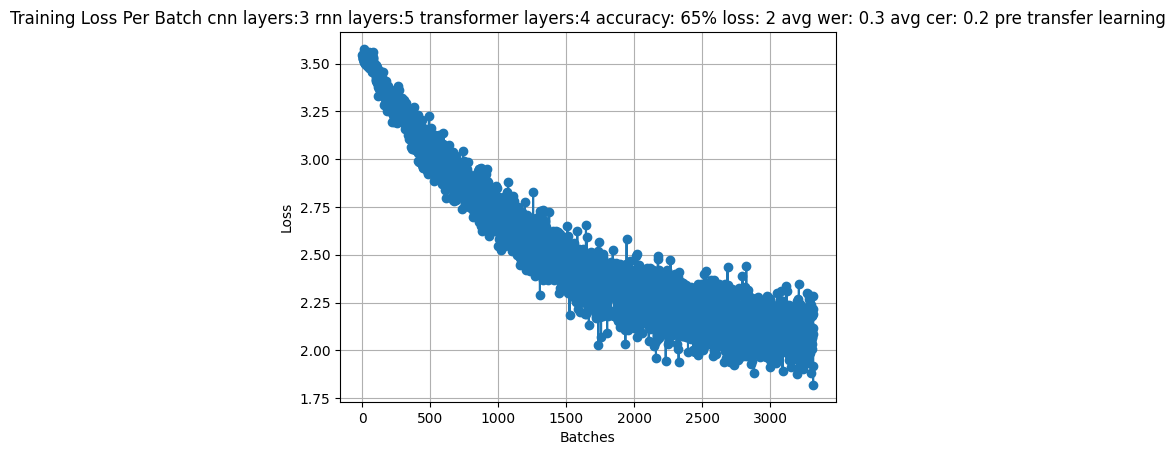

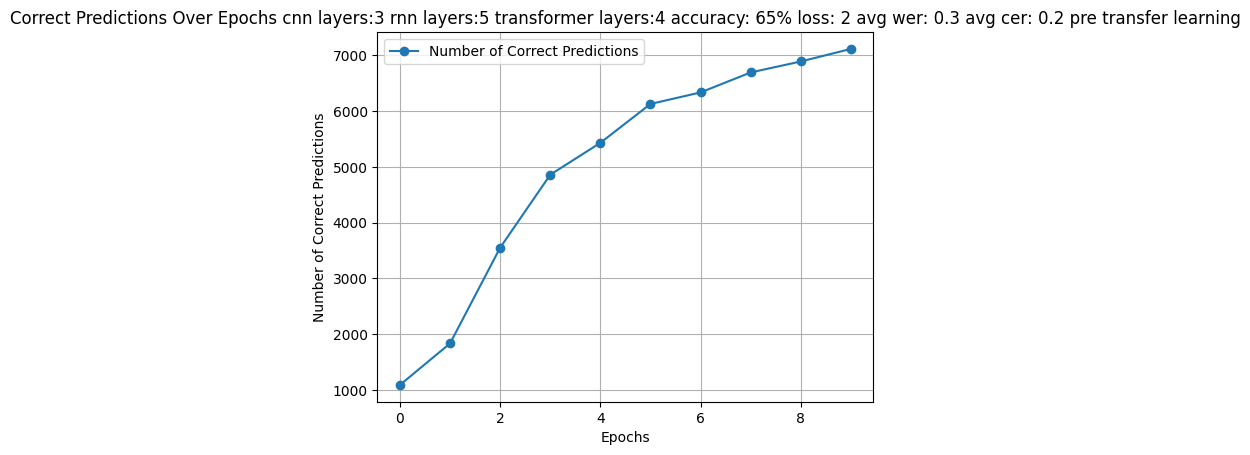

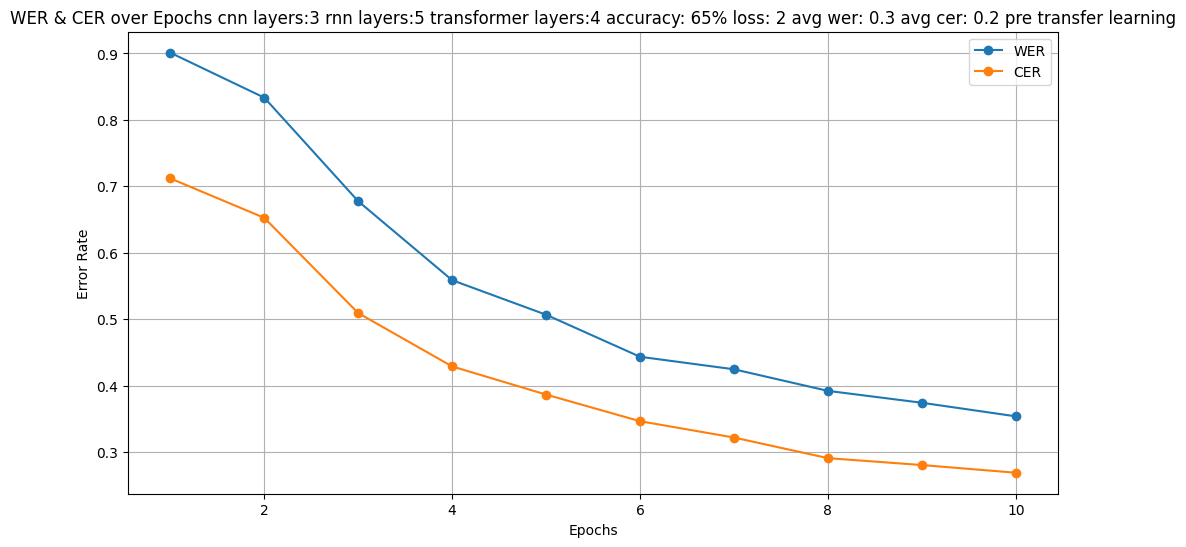

In [23]:



# Let's plot the training metrics versus the number of iteration.
# WER Plotvimport matplotlib.pyplot as plt
epochs = list(range(1, 10))

#loss
plt.plot(loss_over_epochs, marker='o', label='Training Loss')
plt.title('Training Loss Per Batch ' + layers)
plt.xlabel("Batches")
plt.ylabel("Loss")
plt.grid()
plt.show()



#pred
plt.plot(correct_predictions_over_epochs, marker='o', label='Number of Correct Predictions')
plt.xlabel('Epochs')
plt.ylabel('Number of Correct Predictions')
plt.title('Correct Predictions Over Epochs '+ layers)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
# Plot WER# Assuming wer_over_epochs and cer_over_epochs have been populated correctly during training:
epochs_range = list(range(1, len(wer_over_epochs) + 1))

plt.plot(epochs_range, wer_over_epochs, label='WER', marker='o')

plt.plot(epochs_range, cer_over_epochs, label='CER', marker='o')
plt.title('WER & CER over Epochs ' + layers)
plt.xlabel('Epochs')
plt.ylabel('Error Rate')
plt.legend()
plt.grid(True)
plt.show()



 

In [20]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, sample_rate, utterance, *_ = train_set[-1]
ipd.Audio(waveform.numpy(), rate=sample_rate)

print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

NameError: name 'transform' is not defined

In [ ]:
for i, (waveform, sample_rate, utterance, *_) in enumerate(test_set):    output = predict(waveform)
if output != utterance:
      ipd.Audio(waveform.numpy(), rate=sample_rate)
      print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")

else:
    print("All examples in this dataset were correctly classified!")
    print("In this case, let's just look at the last data point")
    ipd.Audio(waveform.numpy(), rate=sample_rate)
    print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")

In [ ]:
!pip install sounddevice

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 2.9 MB/s eta 0:00:00a 0:00:01


Please speak the label: six


Recording...
Recording done.
Please speak the label: no
Recording...
Recording done.
Please speak the label: go
Recording...
Recording done.
Please speak the label: right
Recording...
Recording done.
Please speak the label: on
Recording...
Recording done.
Please speak the label: sheila
Recording...
Recording done.
Please speak the label: right
Recording...
Recording done.
Please speak the label: no
Recording...
Recording done.
Please speak the label: dog
Recording...
Recording done.
Please speak the label: yes
Recording...
Recording done.
Please speak the label: no
Recording...
Recording done.
Please speak the label: dog
Recording...
Recording done.
Please speak the label: on
Recording...
Recording done.
Please speak the label: seven
Recording...
Recording done.
Please speak the label: off
Recording...
Recording done.
Please speak the label: tree
Recording...
Recording done.
Please speak the label: tree
Recording...
Recording done.
Please speak the label: five
Recording...
Recording do

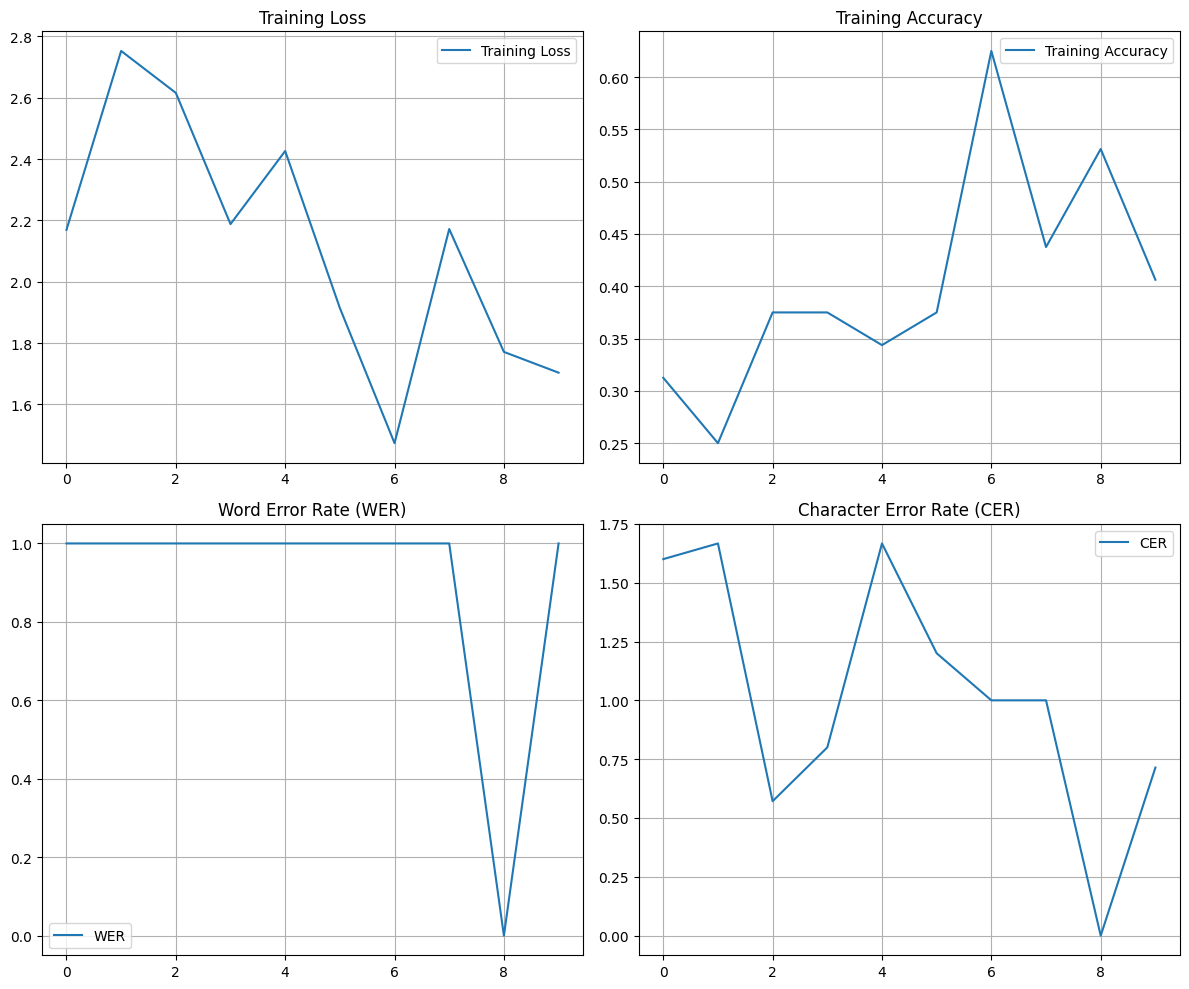

In [ ]:
import sounddevice as sd
import numpy as np
import torch
import torchaudio.transforms as T
import random
import matplotlib.pyplot as plt
import torch

# Variables you might want to change 
pth = "results/experiment1/models/nueraspeech.pth"
model.load_state_dict(torch.load(pth))
model.eval()  # Set the model to evaluation mode
duration = 2  # seconds
# Defining functions 

def record_audio():
    input("Press Enter to start recording...")
    print("Recording...")
    audio = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1, dtype=np.float32)
    sd.wait()
    print("Recording done.")
    return torch.tensor(audio).squeeze()

def live_validate(model, features, true_label_text):
    model.eval()
    with torch.no_grad():
        # Model forward pass
        outputs = model(features)

        # Get predicted label
        predicted_label_index = outputs.argmax(dim=1).item()
        predicted_label_text = labels[predicted_label_index]

        # Compute WER and CER
        wer_score = wer([true_label_text], [predicted_label_text])
        cer_score = cer(true_label_text, predicted_label_text)

    return predicted_label_text, wer_score, cer_score

# Lists 
# to store metrics for plotting
wer_over_epochs = []
cer_over_epochs = []
loss_over_epochs = []
accuracy_over_epochs = []
batch_size = 32



num_epochs = 10

for epoch in range(num_epochs):
    model.train()

    for _ in range(len(labels) // batch_size):
        # Record multiple samples
        waveforms = []
        true_labels = []
        for _ in range(batch_size):
            true_label_index = random.randint(0, len(labels) - 1)
            true_label_text = labels[true_label_index]
            print(f"Please speak the label: {true_label_text}")
            waveform = record_audio()
            waveforms.append(waveform)
            true_labels.append(true_label_index)

        # Preprocess the data
        features = [mel_spectrogram_transform(w) for w in waveforms]
        features = torch.stack(features)
        true_labels = torch.tensor(true_labels)

        # Model forward pass
        outputs = model(features)

        # Compute loss
        loss = F.nll_loss(outputs, true_labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
# Compute accuracy
        pred = outputs.argmax(dim=1, keepdim=True)
        correct = pred.eq(true_labels.view_as(pred)).sum().item()
        accuracy = correct / batch_size


        loss_over_epochs.append(loss.item())

        print("Please provide an audio sample for validation:")
        val_waveform = record_audio()
        val_features = mel_spectrogram_transform(val_waveform)
        val_features = val_features.squeeze(0).unsqueeze(0)  # Adjusting dimensions
        predicted_label, wer_score, cer_score = live_validate(model, val_features, true_label_text)

        print(f"Model's prediction: {predicted_label}\nWER: {wer_score}\nCER: {cer_score}\n")
    # Store metrics
    accuracy_over_epochs.append(accuracy)
    wer_over_epochs.append(wer_score)
    cer_over_epochs.append(cer_score)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Accuracy: {accuracy*100:.2f}%\n")


    torch.save(model.state_dict(), pth)
    print("saved")

# Plot metrics
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs[0, 0].plot(loss_over_epochs, label='Training Loss')
axs[0, 0].set_title('Training Loss')
axs[0, 1].plot(accuracy_over_epochs, label='Training Accuracy')
axs[0, 1].set_title('Training Accuracy')
axs[1, 0].plot(wer_over_epochs, label='WER')
axs[1, 0].set_title('Word Error Rate (WER)')
axs[1, 1].plot(cer_over_epochs, label='CER')
axs[1, 1].set_title('Character Error Rate (CER)')

for ax in axs.flat:
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


In [ ]:

        print("Please provide an audio sample for validation:")
        val_waveform = record_audio()
        val_features = mel_spectrogram_transform(val_waveform)
        val_features = val_features.squeeze(0).unsqueeze(0)  # Adjusting dimensions
        predicted_label, wer_score, cer_score = live_validate(model, val_features, true_label_text)

        print(f"Model's prediction: {predicted_label}\nWER: {wer_score}\nCER: {cer_score}\n")

Please provide an audio sample for validation:
Recording...
Recording done.
Model's prediction: cat
WER: 1.0
CER: 1.4



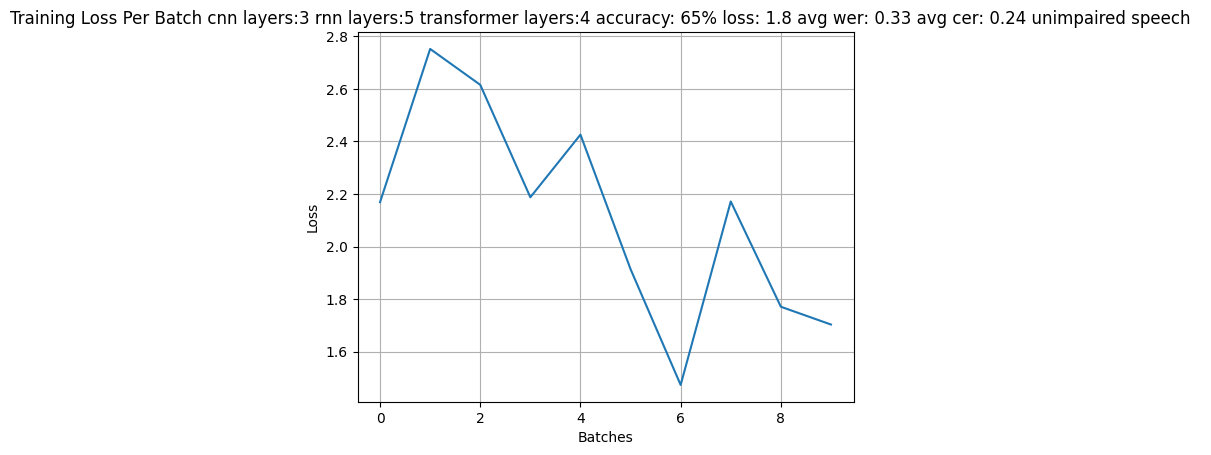

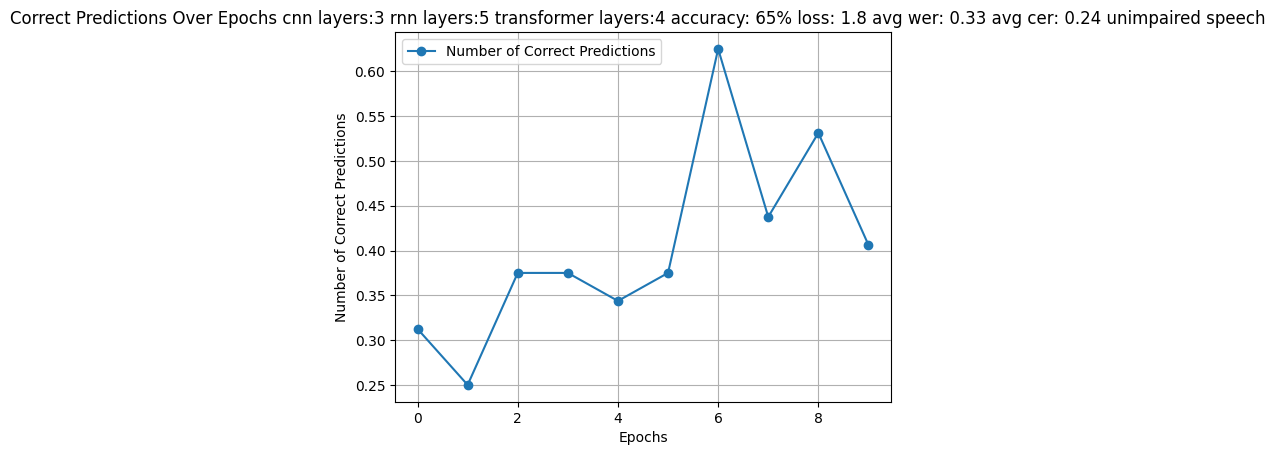

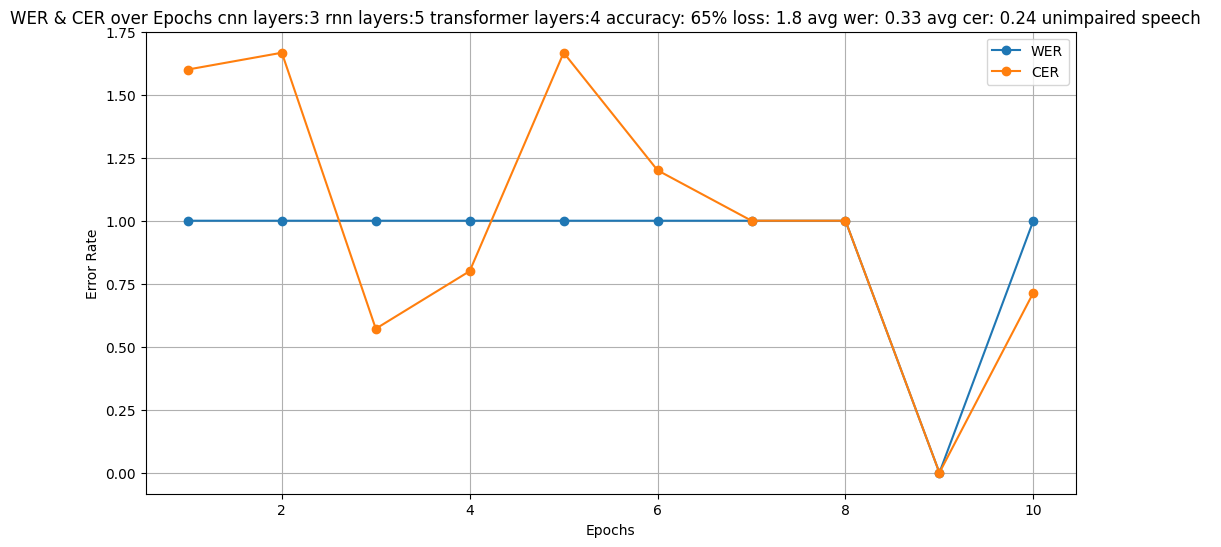

In [ ]:



# Let's plot the training metrics versus the number of iteration.
# WER Plotvimport matplotlib.pyplot as plt
epochs = list(range(1, 10))

#loss
plt.plot(loss_over_epochs)
plt.title('Training Loss Per Batch ' + layers)
plt.xlabel("Batches")
plt.ylabel("Loss")
plt.grid()
plt.show()



#pred
plt.plot(accuracy_over_epochs, marker='o', label='Number of Correct Predictions')
plt.xlabel('Epochs')
plt.ylabel('Number of Correct Predictions')
plt.title('Correct Predictions Over Epochs '+ layers)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
# Plot WER# Assuming wer_over_epochs and cer_over_epochs have been populated correctly during training:
epochs_range = list(range(1, len(wer_over_epochs) + 1))

plt.plot(epochs_range, wer_over_epochs, label='WER', marker='o')

plt.plot(epochs_range, cer_over_epochs, label='CER', marker='o')
plt.title('WER & CER over Epochs ' + layers)
plt.xlabel('Epochs')
plt.ylabel('Error Rate')
plt.legend()
plt.grid(True)
plt.show()



 